# This notebook contains code to compare KMeans Clustering and Hierarchical clustering to determine which is more effective and some initial concepts on Cluster Drift

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
df_raw = pd.read_csv("data/Sample_Superstore_v2.csv",
                     encoding='latin1')

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [4]:
df_raw.describe(include=['O'])

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994
unique,5009,1237,1334,4,793,793,3,1,531,49,4,1862,3,17,1850
top,CA-2017-100111,9/5/2016,12/16/2015,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope
freq,14,38,35,5968,37,37,5191,9994,915,2001,3203,19,6026,1523,48


In [5]:
df_key_fields = df_raw[['Customer ID', 'Sub-Category', 'Sales']].copy()

In [8]:
df_cust_sales = df_key_fields.pivot_table(values = 'Sales',
                                          columns = 'Sub-Category',
                                          aggfunc=np.sum,
                                          index='Customer ID').reset_index()

In [9]:
df_cust_sales.head()

Sub-Category,Customer ID,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
0,AA-10315,41.72,415.92,NaN,685.108,NaN,NaN,NaN,NaN,2.304,14.56,NaN,NaN,14.940,431.976,26.960,3930.072,NaN
1,AA-10375,649.95,NaN,5.248,74.004,NaN,NaN,NaN,NaN,NaN,28.40,NaN,NaN,80.080,116.980,101.728,NaN,NaN
2,AA-10480,479.97,NaN,8.640,NaN,NaN,NaN,NaN,NaN,NaN,27.46,NaN,NaN,108.522,209.970,508.110,NaN,447.84
3,AA-10645,NaN,NaN,5.280,113.940,1279.165,2347.888,NaN,43.96,NaN,123.66,NaN,NaN,119.280,354.682,699.080,NaN,NaN
4,AB-10015,NaN,NaN,17.940,NaN,341.960,48.712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.980,255.564,NaN,NaN


In [10]:
df_cust_sales.fillna(0, inplace=True)

In [11]:
df_cust_sales.iloc[:,1:] = df_cust_sales.iloc[:,1:].applymap(lambda x: np.log(x+1))

In [12]:
df_cust_sales.fillna(0.0, inplace=True)

In [14]:
df_for_pca = df_cust_sales.iloc[:,1:].copy()

## Clustering by Employing K Means

In [18]:
pca = PCA()
df_pca = pca.fit_transform(df_for_pca)
exp_var = np.cumsum(pca.explained_variance_ratio_)

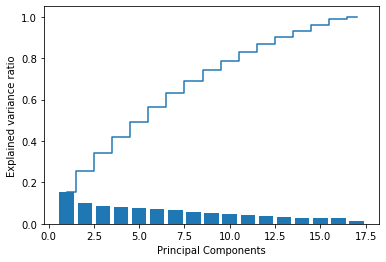

In [16]:
plt.bar(range(1,df_pca.shape[1]+1),pca.explained_variance_ratio_,align='center')
plt.step(range(1,df_pca.shape[1]+1 ), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Components')

plt.show()

In [19]:
#Masking based on 90% variance ratio explained 
exp_var = np.ma.MaskedArray(exp_var, exp_var<0.9)
exp_var

masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --,
                   0.9012439180276832, 0.931518409133049,
                   0.9609887384148906, 0.9866734590101903, 1.0],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True, False, False, False, False,
                   False],
       fill_value=1e+20)

In [20]:
#Find number of components based on 90% variance ratio explained 
n_components = np.argmin(exp_var)
print(n_components)

12


In [21]:
pca_components = PCA(n_components = n_components)

In [22]:
pca_arr = pca_components.fit_transform(df_for_pca)

C:\Users\wengz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


29


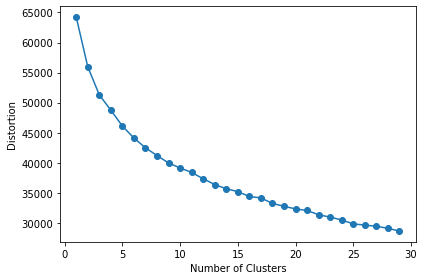

In [23]:
distortions = []
for i in range(1,30):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(pca_arr)
    distortions.append(km.inertia_)

print(len(distortions))
plt.plot(range(1,len(distortions)+1), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [24]:
km_final = KMeans(n_clusters=25,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
results = km_final.fit_predict(pca_arr)

In [25]:
unique_elements, counts_elements = np.unique(results, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24]
 [38 24 35 29 38 33 33 33 34 22 34 17 42 37 28 30 23 36 25 41 41 28 26 31
  35]]


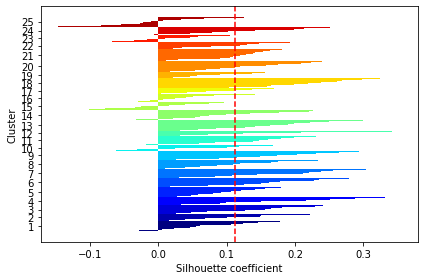

In [26]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(results)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(pca_arr, results, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[results == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('figures/10_04.png', dpi=300)
plt.show()

## Clustering by employing Hierarchical Clustering

In [28]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [37]:
row_clusters = linkage(df_for_pca.values, method='ward', metric='euclidean')
df_hc = pd.DataFrame(row_clusters, 
                     columns=['row label 1', 'row label 2',
                              'distance', 'no. of items in clust.'],
                     index=[f'Merge {(i + 1)}'
                            for i in range(row_clusters.shape[0])])

In [38]:
df_hc.head(10)

,row label 1,row label 2,distance,no. of items in clust.
Merge 1,49.0,266.0,0.508526,2.0
Merge 2,145.0,456.0,1.022159,2.0
Merge 3,14.0,173.0,1.794629,2.0
Merge 4,25.0,97.0,1.981793,2.0
Merge 5,137.0,197.0,2.093164,2.0
Merge 6,512.0,535.0,2.377934,2.0
Merge 7,404.0,461.0,2.393377,2.0
Merge 8,134.0,561.0,2.491636,2.0
Merge 9,248.0,767.0,2.533164,2.0
Merge 10,611.0,681.0,2.586114,2.0


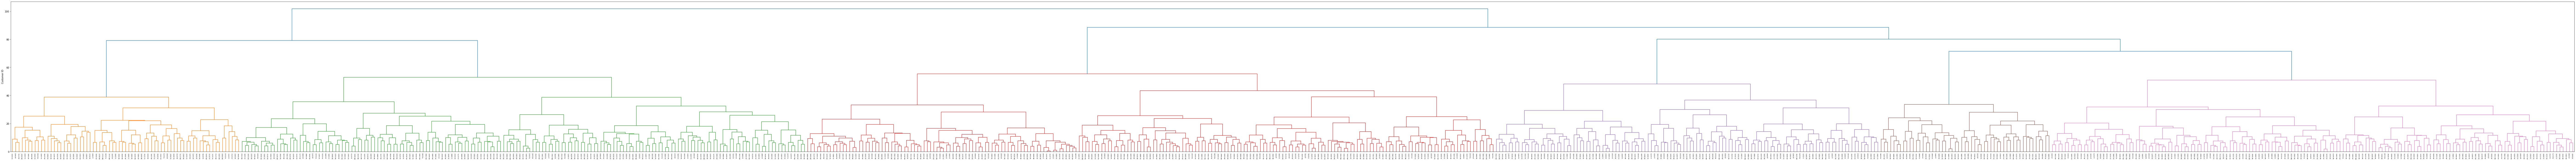

In [48]:
labels = df_cust_sales.iloc[:,0].values
plt.figure(figsize=(200,12))
row_dendr = dendrogram(row_clusters, 
                       labels=labels
                      )
plt.ylabel('Euclidean distance')
plt.xlabel('Customer ID')
plt.show()

In [35]:
# Finding the merge based on 60% of merges
merge_threshold = 0.6
row = int(merge_threshold * df_hc.shape[0])
distance_threshold = df_hc.iloc[row,2]
print(row, distance_threshold)

475 8.984346797860406


In [49]:
#Use Agglomerative Clustering based on Threshold 
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=None, 
                             distance_threshold=distance_threshold,
                             affinity='euclidean',
                             linkage='ward')

hc_cluster = ac.fit_predict(df_for_pca.values)

In [51]:
hc_cluster.min()

0